In [1]:
import pandas as pd
import dalmatian
import matplotlib.pyplot as plt
import numpy as np
import subprocess
import matplotlib
import copy
import os
import seaborn as sns
import scipy.stats as stats
import pickle
import signatureanalyzer as sa
from statannotations.Annotator import Annotator

import warnings
warnings.filterwarnings("ignore")

from statsmodels.stats.multitest import multipletests

plt.rcParams["figure.figsize"] = (12,7)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['figure.dpi'] = 150
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20

import sys
sys.path.append('../utility_code/')
import general_utils as utils

import warnings
warnings.filterwarnings('ignore')

In [2]:
'''
loading maf file
'''

maf_file = '../data/final_pairs.aggregated.tsv'
maf = pd.read_csv(maf_file, sep='\t')
maf['Tumor_Sample_Barcode'] = maf['sample']

In [3]:
'''
grabbing annotation file
'''
df_annot = pd.read_csv('../data/sample_annotations.tsv', sep='\t')


'''
subsetting maf file to coding mutations
'''
df_filt_maf = maf[maf['Variant_Classification'].isin(["Missense_Mutation","Nonsense_Mutation","Splice_Site",
                                                            "Nonstop_Mutation","Frame_Shift_Ins","Frame_Shift_Del", 
                                                            "De_novo_Start_InFrame","Start_Codon_SNP", "In_Frame_Del",
                                                            "In_Frame_Ins","De_novo_Start_OutOfFrame","Start_Codon_Del",
                                                            "Stop_Codon_Del"])]
'''
counting tmbs
'''
df_maf = df_filt_maf.copy()
samp_tmbs = {}
for samp in df_maf['sample'].unique():
    samp_tmbs[samp] = len(df_filt_maf[(df_filt_maf['sample']==samp)&(df_filt_maf['ccf_hat']>.75)]) / 30

'''
merging tmb and annotation dataframe
'''
df_tmb = pd.DataFrame.from_dict(samp_tmbs, orient='index')
df_tmb['tmb_clonal'] = df_tmb[0]
df_tmb.drop(columns=[0], inplace=True)
df_tmb['sample'] = df_tmb.index
df = pd.merge(df_tmb, df_annot, on='sample', how='left')
df.set_index('analysis_id', inplace=True)


'''
groups for boxplot:
cfDNA_earliest, cfDNA_latest, baseline_tissue, baseline_tissue_w_prior_io, baseline_tissue_wo_prior_io
'''
groups = []
for part in df['participant'].unique():
    df_sub = df[df['participant']==part]
    
    if df_sub['indicator'].isin(['S']).any():
        samp = df_sub.reset_index().set_index('indicator').loc['S']['analysis_id']
        df.loc[samp, 'sample_group'] = 'cfDNA_earliest'
        
    elif df_sub['indicator'].isin(['C1D1']).any():
        samp = df_sub.reset_index().set_index('indicator').loc['C1D1']['analysis_id']
        df.loc[samp, 'sample_group'] = 'cfDNA_earliest'
        
        
    if df_sub['indicator'].isin(['EOT']).any():
        samp = df_sub.reset_index().set_index('indicator').loc['EOT']['analysis_id']
        df.loc[samp, 'sample_group'] = 'cfDNA_latest'

    tissue_samp = None
    
    df_tiss = df_sub[df_sub['pdb_original_material_type']=='tissue']
    
    if len(df_tiss) == 1:
        tissue_samp = df_tiss.index.item()
    elif len(df_tiss) > 1: #multiple tissue samples
        if part in ['MCC024']:
            tissue_samp = df_tiss.reset_index().set_index('indicator').loc['prim']['analysis_id']
        elif part == 'MCC008':
            tissue_samp = 'M008-NR-prim'
        else:
            df_tiss = df_tiss[~df_tiss['indicator'].isin(['post_tiss', 'post_tiss-1', 'post_tiss-2'])]
            tissue_samp = df_tiss[df_tiss['collection_date_dfd']==max(df_tiss['collection_date_dfd'])].index.item()
            
    if tissue_samp is not None:
        df_concat = None
        
        df.loc[tissue_samp, 'sample_group'] = 'baseline_tissue'
        
        if df_sub.loc[tissue_samp]['prior_therapy'] == 'Prior IO':
            df_concat = df[df.index==tissue_samp]
            df_concat.loc[tissue_samp, 'sample_group'] = 'tissue_w_prior_io'
            
        elif df_sub.loc[tissue_samp]['prior_therapy'] == 'No Prior IO':
            df_concat = df[df.index==tissue_samp]
            df_concat.loc[tissue_samp, 'sample_group'] = 'tissue_wo_prior_io'
            
        if df_concat is not None:
            df = pd.concat([df, df_concat])

In [5]:
'''
loading nmf results
'''
res_supervised = pd.read_pickle('../data/supervised_nmf_results.ob')

W = res_supervised['W']
H = res_supervised['H']


'''
loading maf
'''
sa_maf, spectra = sa.spectra.get_spectra_from_maf(maf, hgfile='hg19.2bit', reference='cosmic3')
W.index = sa.plotting._muts._map_sbs_sigs_back(W)
df_maf = sa.utils.assign_signature_weights_to_maf(sa_maf, W, H)

'''
loading annotation file and merging
'''
# coding mutations
df_maf = df_maf[df_maf['Variant_Classification'].isin(["Missense_Mutation","Nonsense_Mutation","Splice_Site",
                                                            "Nonstop_Mutation","Frame_Shift_Ins","Frame_Shift_Del", 
                                                            "De_novo_Start_InFrame","Start_Codon_SNP", "In_Frame_Del",
                                                            "In_Frame_Ins","De_novo_Start_OutOfFrame","Start_Codon_Del",
                                                            "Stop_Codon_Del"])]
# clonal mutations
df_maf = df_maf[df_maf['ccf_hat']>.75]

# combining apobec signatures
df_maf['SBS2_13'] = df_maf['SBS2'] + df_maf['SBS13']
sigs = ['SBS1', 'SBS4', 'SBS5', 'SBS2_13']


h_dict = {}

for samp in df_maf['sample'].unique():
    h_dict[samp] = [sum(df_maf[df_maf['sample']==samp][sig]) for sig in sigs]
    
df_h = pd.DataFrame.from_dict(h_dict, orient='index', columns=sigs)

'''
merge annotation file
'''
df_h = df_h.join(df_annot.set_index('sample'), how='left')

'''
getting baseline tissue samples
'''
samples = utils.list_most_recent_tissue_samples(df_h)

'''
converting no. mutations to mut/mb
'''

for sig in sigs:
    df_h.loc[:, sig+'_plot'] = np.maximum(.1, df_h.loc[:, sig] / 30)
    
df_h.head()

,SBS1,SBS4,SBS5,SBS2_13,Unnamed: 0.1,Unnamed: 0,participant,pdb_original_material_type,pdb_preservation_method,pdb_tumor_normal,...,tumor_state,collection_date_dfd,indicator,analysis_id,participant_analysis_id,P/M,SBS1_plot,SBS4_plot,SBS5_plot,SBS2_13_plot
06S20018269,13.608333,26.271750,57.570030,4.549887,41,41,OSU02-088,tissue,FFPE,tumor,...,NaN,0.0,tiss,M088-NR-tiss,M088-NR,NaN,0.453611,0.875725,1.919001,0.151663
06S21063827,12.905338,0.000000,8.519115,3.575547,124,124,OSU02-092,tissue,FFPE,tumor,...,NaN,0.0,tiss,M092-NR-tiss,M092-NR,Metastasis,0.430178,0.100000,0.283970,0.119185
06S21063928,24.305367,7.512572,19.595310,535.586740,347,347,OSU02-099,tissue,FFPE,tumor,...,NaN,0.0,tiss,M099-R-tiss,M099-R,Metastasis,0.810179,0.250419,0.653177,17.852891
06S21063929,14.187753,4.793431,15.875568,5.143248,98,98,OSU02-100,tissue,FFPE,tumor,...,NaN,0.0,tiss,M100-NR-tiss,M100-NR,Metastasis,0.472925,0.159781,0.529186,0.171442
06S21063934,22.350368,23.125179,57.936616,5.587837,45,45,OSU02-098,tissue,FFPE,tumor,...,NaN,0.0,tiss,M098-NR-tiss,M098-NR,Primary,0.745012,0.770839,1.931221,0.186261


In [6]:
'''
combining dataframes
'''

plot_df = df[df['sample_group'].isin(['baseline_tissue', 'tissue_wo_prior_io'])]
plot_df = plot_df.rename(columns={'tmb_clonal':'tmb'})
plot_df = plot_df.reset_index()
plot_df = plot_df.rename(columns={'sample_group':'variable'})


df_plot_h = df_h.melt(id_vars='analysis_id', value_vars=['SBS1', 'SBS4', 'SBS5', 'SBS2_13'],value_name='tmb').merge(df_annot[['analysis_id', 'treatment_response', 'hpv_status']], on='analysis_id')
df_plot_h = df_plot_h[df_plot_h['analysis_id'].isin(plot_df['analysis_id'])]
df_plot_h['tmb'] = df_plot_h['tmb'] / 30

plot_df = pd.concat([plot_df, df_plot_h]).reset_index()

In [8]:
'''
ptesting and calculating median tmb
'''

df_pval = pd.DataFrame(columns=['pval'])
df_median = pd.DataFrame(columns=['median'])
sigs = ['SBS1', 'SBS4', 'SBS5', 'SBS2_13']
variables = ['baseline_tissue', 'SBS1', 'SBS4', 'SBS5', 'SBS2_13']


for index in range(len(variables)):
    
    group = variables[index]
    
    a = plot_df[(plot_df['variable']==group)&(plot_df['hpv_status']=='Positive')]['tmb']
    b = plot_df[(plot_df['variable']==group)&(plot_df['hpv_status']=='Negative')]['tmb']    
    p = stats.ranksums(a, b)[1]
    
    df_pval.loc[group] = p

    df_median.loc[f'{group}——Positive', 'median'] = np.median(a)
    df_median.loc[f'{group}——Negative', 'median'] = np.median(b)
    
df_pval.loc[sigs, 'qval'] = multipletests(df_pval.loc[sigs, 'pval'], method='fdr_bh')[1]
df_pval.loc[sigs, 'annot'] = 'q=' + round(df_pval.loc[sigs, 'qval'], 3).astype('string')
df_pval.loc['baseline_tissue', 'annot'] = 'p=' + str(round(df_pval.loc['baseline_tissue', 'pval'], 3))

display(df_median)
display(df_pval)

,median
baseline_tissue——Positive,1.5
baseline_tissue——Negative,2.166667
SBS1——Positive,0.431289
SBS1——Negative,0.520745
SBS4——Positive,0.039802
SBS4——Negative,0.208444
SBS5——Positive,0.529186
SBS5——Negative,1.007094
SBS2_13——Positive,0.382721
SBS2_13——Negative,0.215848


,pval,qval,annot
baseline_tissue,0.050209,NaN,p=0.05
SBS1,0.496062,0.661416,q=0.661
SBS4,0.001254,0.002508,q=0.003
SBS5,0.000230,0.000921,q=0.001
SBS2_13,0.815671,0.815671,q=0.816


In [9]:
'''
creating minimum value for log scale
'''

plot_df['tmb'] = np.maximum(plot_df['tmb'], 1e-1*np.ones((len(plot_df))))

print(min(plot_df['tmb']))

0.1


In [10]:
'''
creating tests for stat annotator
'''

tests=[]
for cat in ['baseline_tissue', 'SBS1', 'SBS4', 'SBS5', 'SBS2_13']:
    tests += [
        ((cat, 'Positive'), (cat, 'Negative'))
    ]
    
'''
colors
'''
import palettable as pal

clinC = pal.cartocolors.qualitative.Vivid_10.mpl_colors

mappings = {}

clinvars = ['Positive', 'No Response', 'MHC-Intact', 'Negative', 'MHC-LOH', 'Response', 'No Prior IO', 'Prior IO', 'History of smoking', 'No history of smoking']
mappings['clinical'] = {clinvars[q]:clinC[q] for q in range(len(clinvars))} | {'Not Assessed':{'facecolor': 'grey', 'alpha': 0.2}}
mappings['clinical']['Response'] = 'tab:green'

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

SBS1_Positive vs. SBS1_Negative: q=0.661
baseline_tissue_Positive vs. baseline_tissue_Negative: p=0.05
SBS4_Positive vs. SBS4_Negative: q=0.003
SBS5_Positive vs. SBS5_Negative: q=0.001
SBS2_13_Positive vs. SBS2_13_Negative: q=0.816


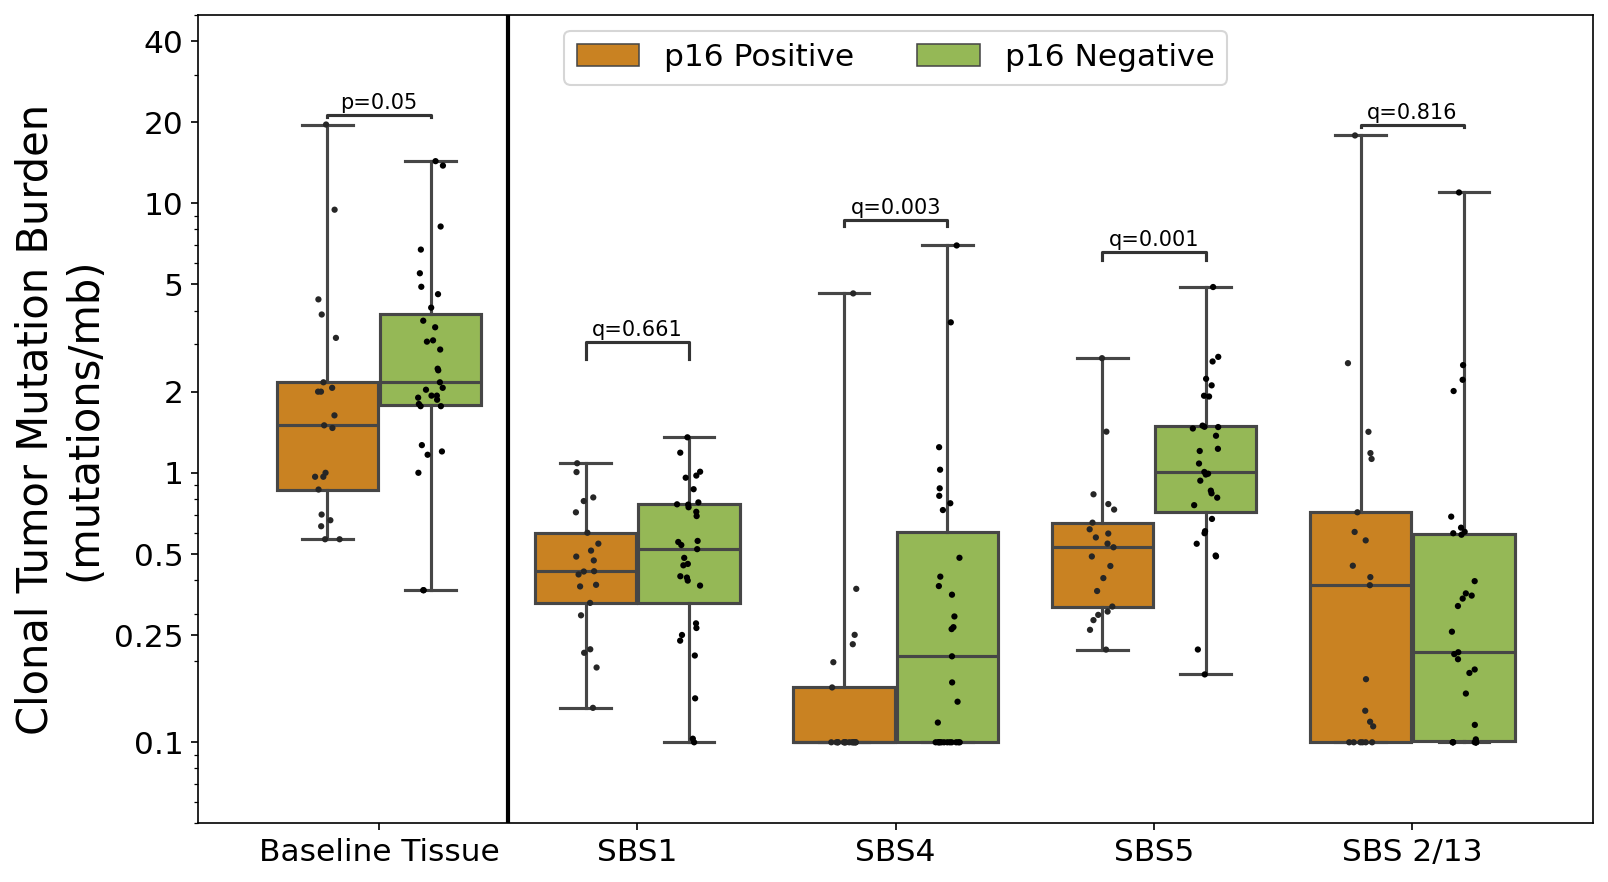

In [11]:
variables = ['baseline_tissue', 'SBS1', 'SBS4', 'SBS5', 'SBS2_13']

plot = plot_df[plot_df['variable'].isin(variables)]
plot = plot[plot['hpv_status'].isin(['Positive', 'Negative'])]

ax = sns.boxplot(data=plot, x='variable', y='tmb', hue='hpv_status',
                 hue_order = ['Positive', 'Negative'], whis=1000,
                 order = variables, palette=mappings['clinical']);

sns.stripplot(data=plot, x='variable', y='tmb', hue='hpv_status', 
                   hue_order = ['Positive', 'Negative'], dodge=True, color='k',
                   order = variables, size=3, ax=ax);

annot = Annotator(ax, tests, data=plot, x='variable', y='tmb', hue='hpv_status', hue_order = ['Positive', 'Negative'])
annots = df_pval.loc[variables, 'annot'].to_list()
annot.configure().set_custom_annotations(annots).annotate();

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], ['p16 Positive', 'p16 Negative'], fontsize=15, ncols=2, title='', title_fontsize=15, loc='upper center')

plt.yscale('log')
plt.ylim(.05, 50)
plt.xlabel('')
plt.xticks(range(5), ['Baseline Tissue', 'SBS1', 'SBS4', 'SBS5', 'SBS 2/13'], size=15)
plt.ylabel('Clonal Tumor Mutation Burden\n(mutations/mb)')

ticks = [.1, .25, .5, 1, 2, 5, 10, 20, 40]
plt.yticks(ticks, ticks, size=15)

plt.axvline(.5, color='black', lw=2);